# Ross Sea synthetic model

Here we create the inversion inputs for a semi-realistic model of the Ross Sea. We create a synthetic gravity dataset which is the forward gravity of 2 density contrasts across real topographic surfaces. The first is the bathymetry from IBCSO. The second is the sediment-basement contact, from the ANTOSTRAT seismic surveys. This forward gravity is then sampled onto a the flight paths of an airborne survey, and noise is added. This represetns the observed gravity of an airborne survey. 

We then create a low-resolution bathymetry by sampling the true bathymetry at a semi-regular grid of "constraint" points, and regrid the surface with just these values. In an Antarctic setting, these points represent single seismic survey locations which image the bathymetry surface. 

This data is then used in notebook `Ross_Sea_synthetic_inversion.ipynb` in a series of inversions.

import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

# local python scripts
from RIS_gravity_inversion import plotting, optimization, synthetic
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import scipy as sp
import rioxarray
import pygmt
import copy
import harmonica as hm
import geopandas as gpd
from shapely.geometry import Polygon

# for plotting
import pvxarray
import matplotlib.pyplot as plt
import holoviews as hv
import hvplot.xarray
import hvplot.pandas
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# hvplot.extension('bokeh', 'matplotlib', 'plotly')
import panel.widgets as pnw
import panel as pn

pn.extension(comms="vscode")

import os

# Synthetic layers

This notebook creates a simple synthetic earth model comprised of 3 topography layers, Layer1, Layer2 and Layer3, representing the ice surface, icebase, and a crustal density contrast, respectively. We will compute the forward gravity of these 3 density contrasts. We will then create a low resolution version of Layer 2, to representing having limited knowledge of the ice-bed interface. We will then attempt to recover the full resolution Layer 2 in a gravity inversion (see `synthetic_inversion_simple_with_regional.ipynb`). The forward gravity of the full resolution layers will be used in the inversion, representing a perfect gravity survey, but the inversion will need to seperate out the regional field created by Layer3.

The layers are created with a series of 2D gaussian function of various wavelengths and amplitudes. 

## Set region and parameters

In [2]:
# polygon = regions.draw_region()

In [3]:
# inversion_region = utils.polygon_to_region(polygon)
# inversion_region

In [4]:
# set grid parameters
layer_spacing = 5e3
registration = "g"
reference = "ellipsoid"

# set gravity observation parameters
grav_observation_height = 1e3
airborne_grav_spacing = 1e3

In [5]:
# inversion_region = utils.alter_region(regions.ross_sea, zoom=200e3,)[0]
inversion_region = [-40e3, 260e3, -1800e3, -1400e3]

buffer_region = utils.alter_region(
    inversion_region,
    buffer=40e3,
)[1]

print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

inversion region =  [-40000.0, 260000.0, -1800000.0, -1400000.0]
buffer region =  [-80000, 300000, -1840000, -1360000]


In [6]:
x_cells = int(abs(buffer_region[0] - buffer_region[1]) / layer_spacing)
y_cells = int(abs(buffer_region[2] - buffer_region[3]) / layer_spacing)
prisms_per_layer = x_cells * y_cells
print(f"x axis prisms: {x_cells}")
print(f"y axis prisms: {y_cells}")
print(f"prisms for bathymetry layer: {prisms_per_layer}")

x axis prisms: 76
y axis prisms: 96
prisms for bathymetry layer: 7296


In [7]:
x_cells = int(abs(inversion_region[0] - inversion_region[1]) / layer_spacing)
y_cells = int(abs(inversion_region[2] - inversion_region[3]) / layer_spacing)
prisms_per_layer = x_cells * y_cells
print(f"x axis prisms: {x_cells}")
print(f"y axis prisms: {y_cells}")
print(
    f"inversion region x range: {abs(inversion_region[0]-inversion_region[1])/1000}km"
)
print(
    f"inversion region y range: {abs(inversion_region[2]-inversion_region[3])/1000}km"
)
print(f"prisms per layer: {prisms_per_layer}")

x axis prisms: 60
y axis prisms: 80
inversion region x range: 300.0km
inversion region y range: 400.0km
prisms per layer: 4800


## Bathymetry

using preprocessed 5km grid since spacing is > 5km


/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


returning grid with new region and/or registration, same spacing
grid info (5000.0, [-80000.0, 300000.0, -1840000.0, -1360000.0], -968.675476074, -168.314071655, 'g')
grid median value: -491.1756


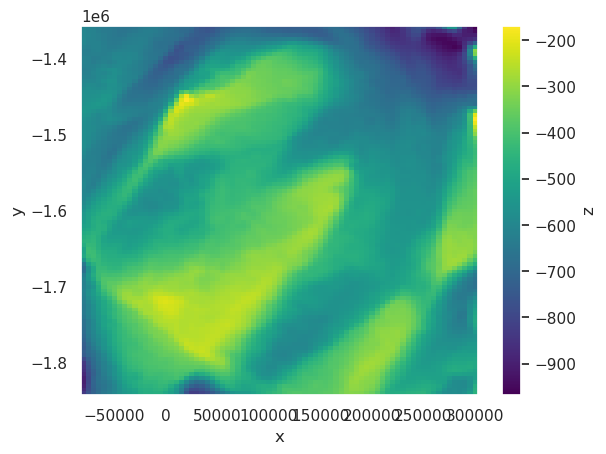

In [8]:
bed = fetch.IBCSO(
    layer="bed",
    region=buffer_region,
    spacing=layer_spacing,
    registration=registration,
)

bed.plot()
print("grid info", utils.get_grid_info(bed))
print("grid median value:", np.median(bed.values))

## Basement

returning grid with new region and/or registration, same spacing
grid info (5000.0, [-80000.0, 300000.0, -1840000.0, -1360000.0], -6545.93701172, -841.826843262, 'g')
grid median value: -2630.1233


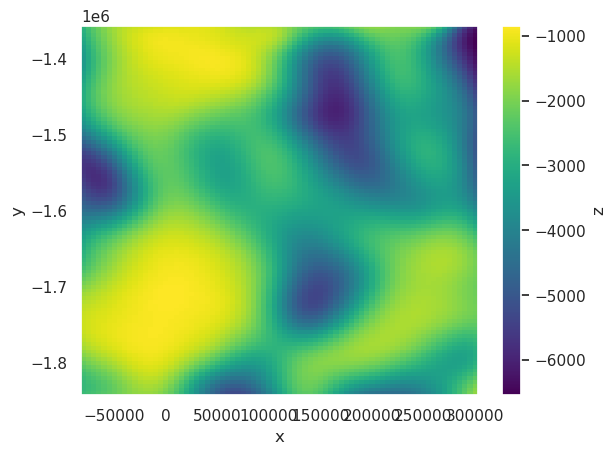

In [9]:
basement = fetch.basement(
    region=buffer_region,
    spacing=layer_spacing,
    registration=registration,
)
basement.plot()

print("grid info", utils.get_grid_info(basement))
print("grid median value:", np.median(basement.values))

## save to .zarr files

In [10]:
# use conventional coordinate names
bed = bed.rename({"x": "easting", "y": "northing"})
basement = basement.rename({"x": "easting", "y": "northing"})

In [11]:
output = bed.to_dataset(name="z")
output.to_zarr(
    "../../synthetic_data/Ross_Sea_bed.zarr",
    encoding={"z": {"compressor": zarr.Blosc()}},
    mode="w",
)

output = basement.to_dataset(name="z")
output.to_zarr(
    "../../synthetic_data/Ross_Sea_basement.zarr",
    encoding={"z": {"compressor": zarr.Blosc()}},
    mode="w",
)

## load .zarr files

In [9]:
bed = xr.open_zarr("../../synthetic_data/Ross_Sea_bed.zarr").z
basement = xr.open_zarr("../../synthetic_data/Ross_Sea_basement.zarr").z

## vizualize

In [16]:
# fig = maps.plot_grd(
#     bed,
#     region=inversion_region,
#     fig_height=10,
#     title="Bathymetry",
#     hist=True,
#     cbar_yoffset=3,
#     grd2_cpt=True,
#     cmap="rain",
#     reverse_cpt=True,
#     cbar_label="elevation (m)",
#     frame=["nSWe", "xaf10000", "yaf10000"],
#     robust=True,
# )

# fig.text(
#     position="TL",
#     text="a)",
#     fill="white",
#     font="20p,Helvetica,black",
#     offset="j0/-1",
#     clearance="+tO",
#     no_clip=True,
# )

# fig = maps.plot_grd(
#     basement,
#     region=inversion_region,
#     fig_height=10,
#     title="Basement",
#     hist=True,
#     cbar_yoffset=3,
#     grd2_cpt=True,
#     cmap="rain",
#     reverse_cpt=True,
#     cbar_label="elevation (m)",
#     frame=["nSwE", "xaf10000", "yaf10000"],
#     fig=fig,
#     origin_shift="xshift",
#     robust=True,
# )

# fig.text(
#     position="TL",
#     text="b)",
#     fill="white",
#     font="20p,Helvetica,black",
#     offset="j0/-1",
#     clearance="+tO",
#     no_clip=True,
# )

# fig.show()

# Observed gravity
Here we use the above three layers to create a synthethic gravity survey.

In [13]:
# make pandas dataframe of locations to calculate gravity
# create lists of coordinates
coords = vd.grid_coordinates(
    region=inversion_region,
    spacing=layer_spacing,
    pixel_register=False,
    extra_coords=grav_observation_height,
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

print(utils.get_grid_info(observations))

observation_points = vd.grid_to_table(observations)

# resample to half spacing to make training / testing points
observation_points = inv_utils.resample_with_test_points(
    layer_spacing, observation_points, inversion_region
)

print(f"number of test points: {len(observation_points[observation_points.test])}")
print(
    f"number of train points: {len(observation_points[observation_points.test == False])}"
)
observation_points

(5000.0, [-40000.0, 260000.0, -1800000.0, -1400000.0], 1000.0, 1000.0, 'g')
number of test points: 14540
number of train points: 4941


northing   easting   test  upward
0     -1800000.0  -40000.0  False  1000.0
1     -1800000.0  -37500.0   True  1000.0
2     -1800000.0  -35000.0  False  1000.0
3     -1800000.0  -32500.0   True  1000.0
4     -1800000.0  -30000.0  False  1000.0
...          ...       ...    ...     ...
19476 -1400000.0  250000.0  False  1000.0
19477 -1400000.0  252500.0   True  1000.0
19478 -1400000.0  255000.0  False  1000.0
19479 -1400000.0  257500.0   True  1000.0
19480 -1400000.0  260000.0  False  1000.0

[19481 rows x 4 columns]

In [14]:
# Bed
density_contrast = 2300 - 1024
grid = bed

zref = np.nanmean(grid.values)
density = xr.where(grid >= zref, density_contrast, -density_contrast)

bed_prisms = inv_utils.grids_to_prisms(
    grid,
    zref,
    density=density,
)

# Basement
density_contrast = 2500 - 2300
grid = basement

zref = np.nanmean(grid.values)
density = xr.where(grid >= zref, density_contrast, -density_contrast)

basement_prisms = inv_utils.grids_to_prisms(
    grid,
    zref,
    density=density,
)

# plotting.show_prism_layers(
#     [
#         surface_prisms,
#         bed_prisms,
#         basement_prisms,
#         ],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     # color_by='constant',
#     log_scale=False,
#     clip_box=False,
#     zscale=20,
# )

In [15]:
forward_grids, forward_df = inv_utils.forward_grav_of_prismlayer(
    [
        bed_prisms,
        basement_prisms,
    ],
    observation_points,
    plot=False,
    names=[
        "bathymetry",
        "basement",
    ],
    remove_mean=False,
    progressbar=True,
)

  0%|                                                 | 0/19481 [00:00<?, ?it/s]

  0%|                                                 | 0/19481 [00:00<?, ?it/s]

In [16]:
# save to a .zarr file
forward_grids.to_zarr(
    "../../synthetic_data/Ross_Sea_forward_grav.zarr",
    mode="w",
)

In [17]:
# load zarr file
forward_grids = xr.open_zarr(
    "../../synthetic_data/Ross_Sea_forward_grav.zarr",
)
forward_grids

<xarray.Dataset>
Dimensions:        (northing: 161, easting: 121)
Coordinates:
  * easting        (easting) float64 -4e+04 -3.75e+04 ... 2.575e+05 2.6e+05
  * northing       (northing) float64 -1.8e+06 -1.798e+06 ... -1.4e+06
Data variables:
    basement       (northing, easting) float64 dask.array<chunksize=(161, 121), meta=np.ndarray>
    bathymetry     (northing, easting) float64 dask.array<chunksize=(161, 121), meta=np.ndarray>
    forward_total  (northing, easting) float64 dask.array<chunksize=(161, 121), meta=np.ndarray>
    test           (northing, easting) bool dask.array<chunksize=(161, 121), meta=np.ndarray>
    upward         (northing, easting) float64 dask.array<chunksize=(161, 121), meta=np.ndarray>

In [18]:
forward_df = vd.grid_to_table(forward_grids)
forward_df

northing   easting   basement  bathymetry  forward_total   test  \
0     -1800000.0  -40000.0  10.954490    1.539214      12.493704  False   
1     -1800000.0  -37500.0  11.301743    2.179182      13.480925   True   
2     -1800000.0  -35000.0  11.628426    2.738309      14.366735  False   
3     -1800000.0  -32500.0  11.926100    3.121790      15.047890   True   
4     -1800000.0  -30000.0  12.197463    3.460530      15.657992  False   
...          ...       ...        ...         ...            ...    ...   
19476 -1400000.0  250000.0  -4.359605  -16.596796     -20.956401  False   
19477 -1400000.0  252500.0  -5.283528  -16.946833     -22.230361   True   
19478 -1400000.0  255000.0  -6.260088  -17.317246     -23.577334  False   
19479 -1400000.0  257500.0  -7.275874  -17.744627     -25.020501   True   
19480 -1400000.0  260000.0  -8.326692  -18.186654     -26.513346  False   

       upward  
0      1000.0  
1      1000.0  
2      1000.0  
3      1000.0  
4      1000.0  
...       ...  
19476  1000.0  
19477  1000.0  
19478  1000.0  
19479  1000.0  
19480  1000.0  

[19481 rows x 7 columns]

#### Save to csv

In [19]:
forward_df.to_csv(
    "../../synthetic_data/Ross_Sea_full_res_gravity.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [20]:
forward_df = pd.read_csv(
    "../../synthetic_data/Ross_Sea_full_res_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
forward_df

northing   easting   basement  bathymetry  forward_total   test  \
0     -1800000.0  -40000.0  10.954490    1.539214      12.493704  False   
1     -1800000.0  -37500.0  11.301743    2.179182      13.480925   True   
2     -1800000.0  -35000.0  11.628426    2.738309      14.366735  False   
3     -1800000.0  -32500.0  11.926100    3.121790      15.047890   True   
4     -1800000.0  -30000.0  12.197463    3.460530      15.657992  False   
...          ...       ...        ...         ...            ...    ...   
19476 -1400000.0  250000.0  -4.359605  -16.596796     -20.956401  False   
19477 -1400000.0  252500.0  -5.283528  -16.946833     -22.230361   True   
19478 -1400000.0  255000.0  -6.260088  -17.317246     -23.577334  False   
19479 -1400000.0  257500.0  -7.275874  -17.744627     -25.020501   True   
19480 -1400000.0  260000.0  -8.326692  -18.186654     -26.513346  False   

       upward  
0      1000.0  
1      1000.0  
2      1000.0  
3      1000.0  
4      1000.0  
...       ...  
19476  1000.0  
19477  1000.0  
19478  1000.0  
19479  1000.0  
19480  1000.0  

[19481 rows x 7 columns]

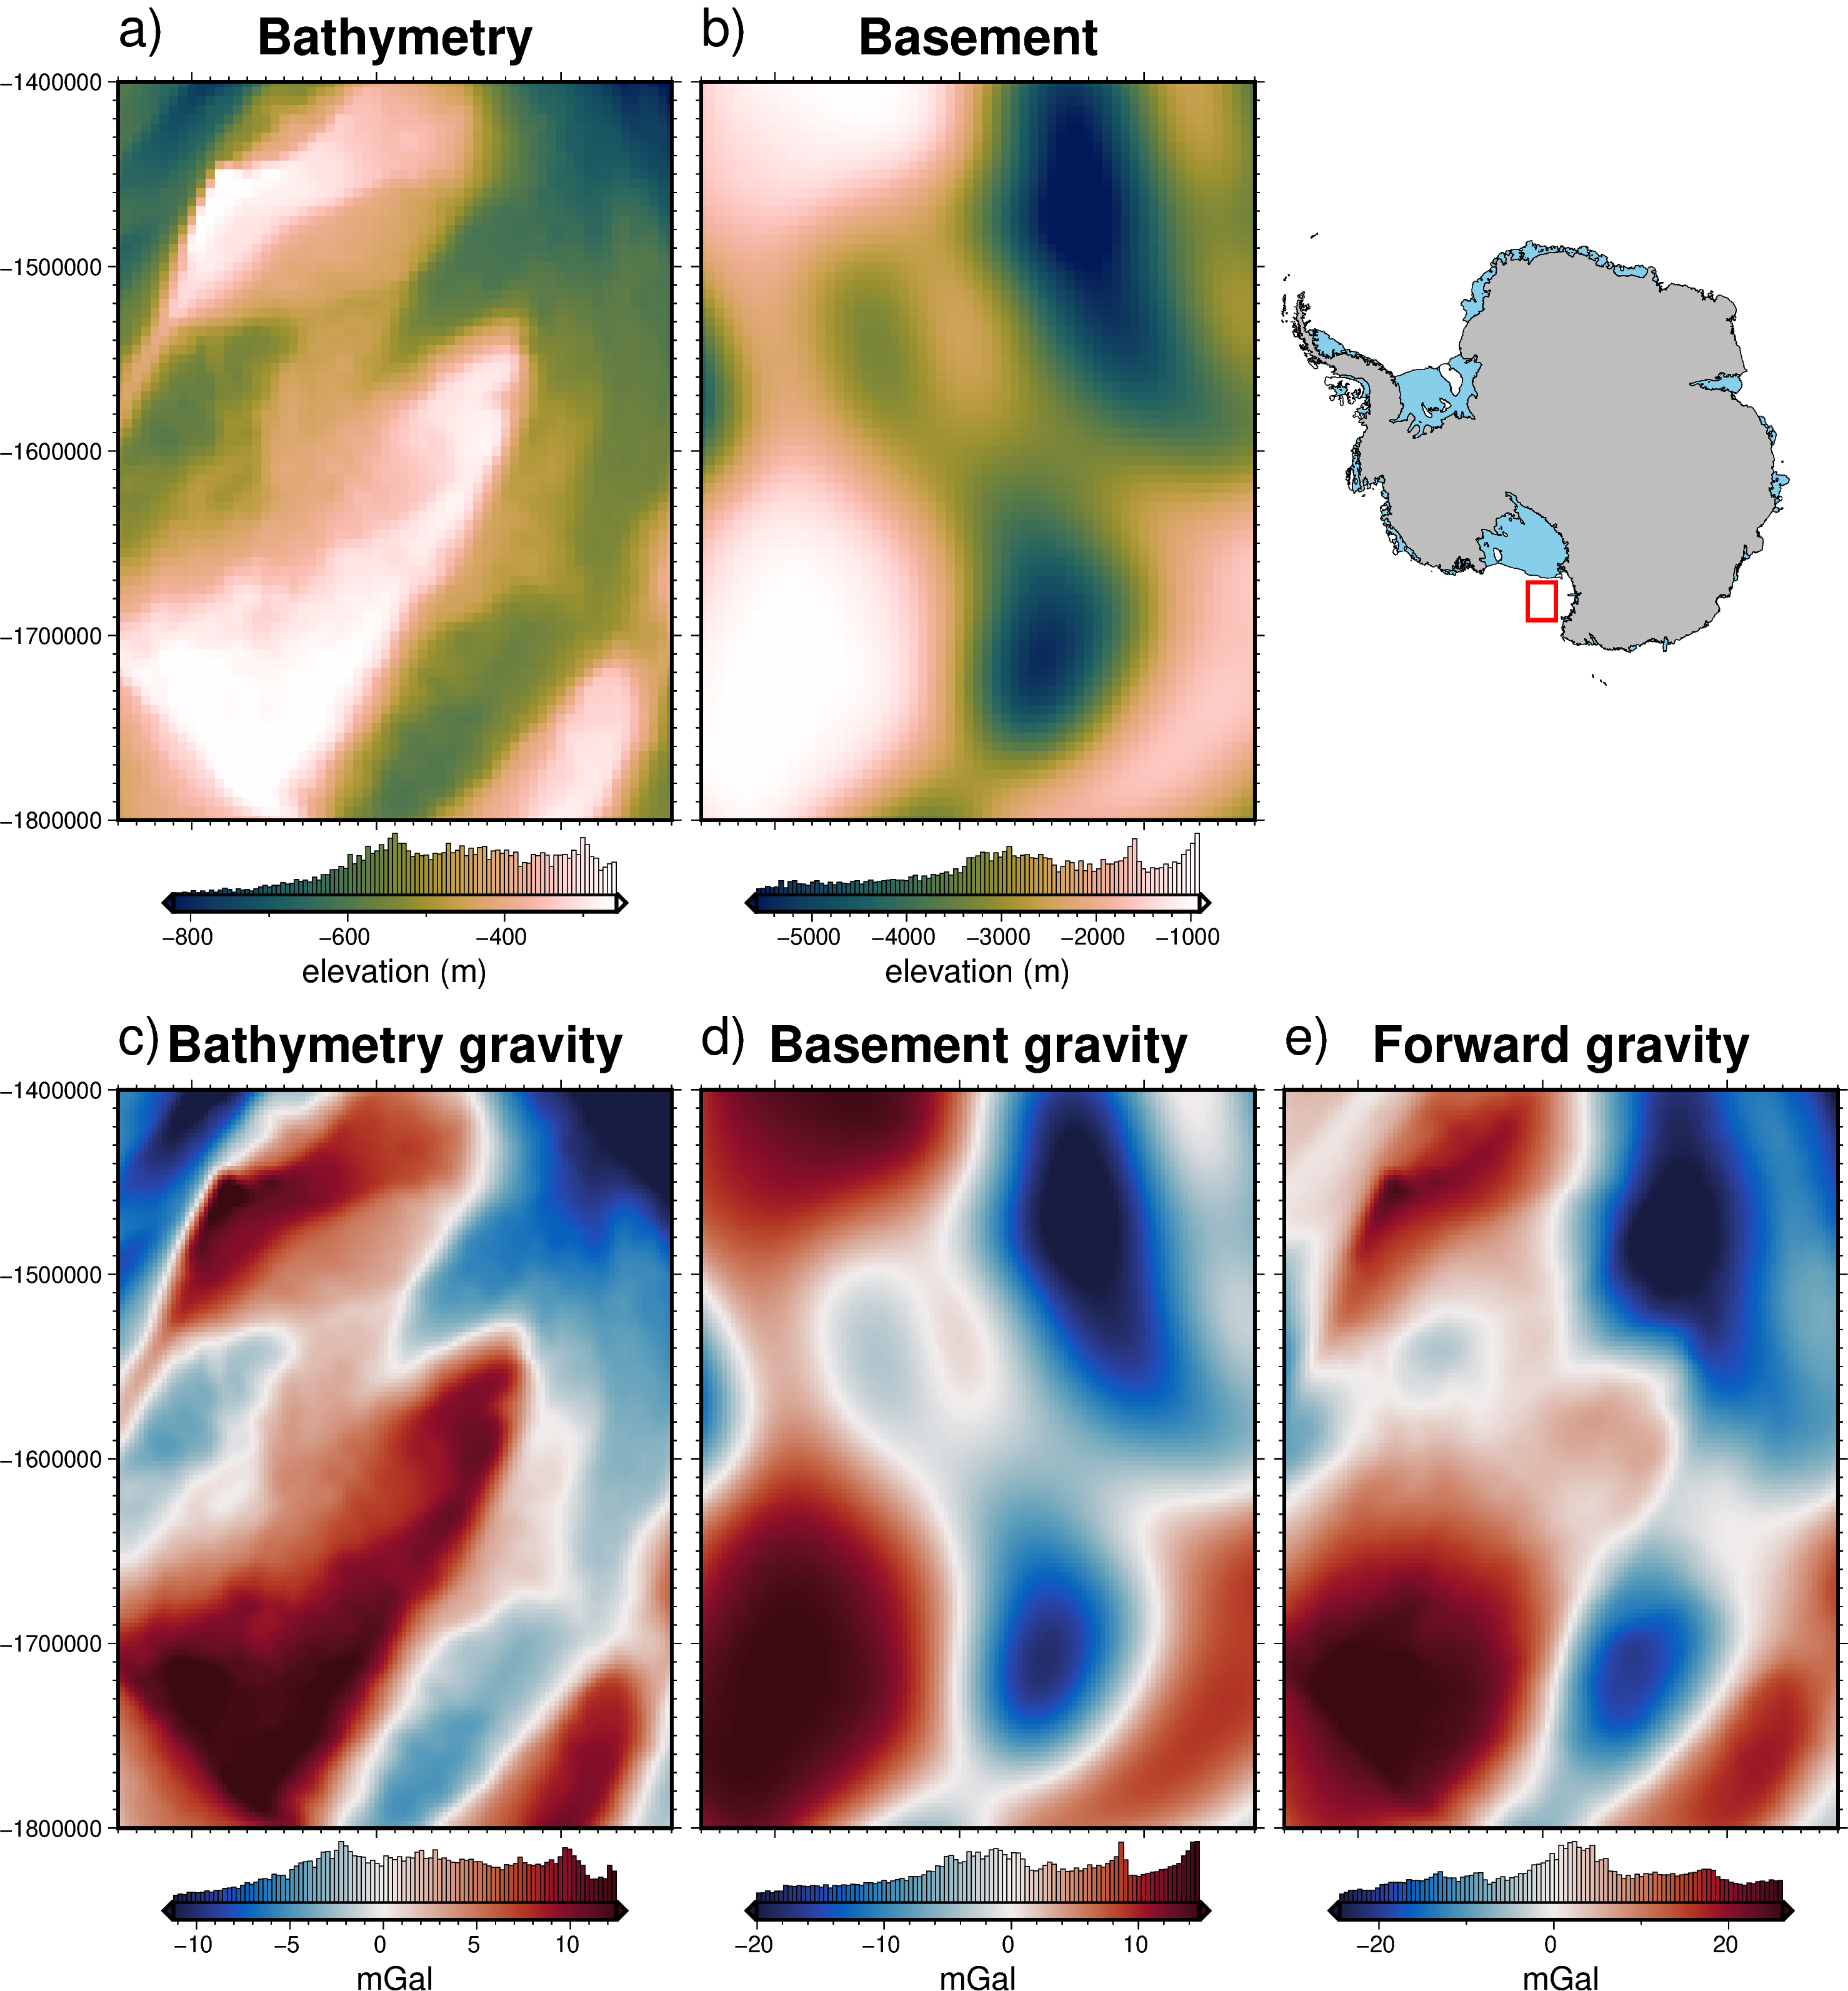

In [46]:
# bathy
fig = maps.plot_grd(
    bed,
    region=inversion_region,
    fig_height=10,
    title="Bathymetry",
    hist=True,
    cbar_yoffset=1,
    grd2_cpt=True,
    cmap="batlowW",
    cbar_label="elevation (m)",
    frame=["nsWe", "xaf10000", "yaf10000"],
    robust=True,
)
fig.text(
    position="TL",
    text="a)",
    fill="white",
    font="20p,Helvetica,black",
    offset="j0/-1",
    clearance="+tO",
    no_clip=True,
)
# basement
fig = maps.plot_grd(
    basement,
    region=inversion_region,
    title="Basement",
    hist=True,
    cbar_yoffset=1,
    grd2_cpt=True,
    cmap="batlowW",
    cbar_label="elevation (m)",
    frame=["nswe", "xaf10000", "yaf10000"],
    fig=fig,
    origin_shift="xshift",
    robust=True,
    inset=True,
    inset_pos="CM",
    inset_width=0.95,
    inset_offset="7.5c/0c",
    inset_box_pen="1.5p,red",
)
fig.text(
    position="TL",
    text="b)",
    fill="white",
    font="20p,Helvetica,black",
    offset="j0/-1",
    clearance="+tO",
    no_clip=True,
)

# bathy grav
fig = maps.plot_grd(
    forward_grids.bathymetry,
    region=inversion_region,
    title="Bathymetry gravity",
    hist=True,
    cbar_yoffset=1,
    cmap="balance+h0",
    cbar_label="mGal",
    frame=["nsWe", "xaf10000", "yaf10000"],
    fig=fig,
    origin_shift="both_shift",
    xshift_amount=-1,
    yshift_amount=-1.05,
    robust=True,
)
fig.text(
    position="TL",
    text="c)",
    fill="white",
    font="20p,Helvetica,black",
    offset="j0/-1",
    clearance="+tO",
    no_clip=True,
)
# basement grav
fig = maps.plot_grd(
    forward_grids.basement,
    region=inversion_region,
    title="Basement gravity",
    hist=True,
    cbar_yoffset=1,
    grd2_cpt=True,
    cmap="balance+h0",
    cbar_label="mGal",
    frame=["nswe", "xaf10000", "yaf10000"],
    fig=fig,
    origin_shift="xshift",
    robust=True,
)
fig.text(
    position="TL",
    text="d)",
    fill="white",
    font="20p,Helvetica,black",
    offset="j0/-1",
    clearance="+tO",
    no_clip=True,
)

# total grav
fig = maps.plot_grd(
    forward_grids.forward_total,
    region=inversion_region,
    title="Forward gravity",
    hist=True,
    cbar_yoffset=1,
    grd2_cpt=True,
    cmap="balance+h0",
    cbar_label="mGal",
    frame=["nswe", "xaf10000", "yaf10000"],
    fig=fig,
    origin_shift="xshift",
    robust=True,
)
fig.text(
    position="TL",
    text="e)",
    fill="white",
    font="20p,Helvetica,black",
    offset="j0/-1",
    clearance="+tO",
    no_clip=True,
)

fig.show()

## Simulate airborne survey

### create observation points

In [24]:
# irregular grid
# offset so doesn't line up with anomalies
offset = 7e3
# simulate N-S tie lines
x = np.arange(inversion_region[0] + offset, inversion_region[1], 50e3)
y = np.arange(inversion_region[2], inversion_region[3], airborne_grav_spacing)
# remove the 3rd and 9th N-S lines
x = np.delete(x, 2)

coords = np.meshgrid(x, y)
# turn coordinates into dataarray
ties = vd.make_xarray_grid(
    coords,
    data=np.ones_like(coords[0]) * 1e3,
    data_names="upward",
    dims=("northing", "easting"),
)
# turn dataarray into dataframe
df_ties = vd.grid_to_table(ties)

# simulate E-W flight lines
x = np.arange(inversion_region[0], inversion_region[1], airborne_grav_spacing)
y = np.arange(inversion_region[2] + offset, inversion_region[3], 15e3)
# remove a few E-W lines, starting from bottom
y = np.delete(y, [3, 8, 17])

coords = np.meshgrid(x, y)
# turn coordinates into dataarray
lines = vd.make_xarray_grid(
    coords,
    data=np.ones_like(coords[0]) * 1e3,
    data_names="upward",
    dims=("northing", "easting"),
)
# turn dataarray into dataframe
df_lines = vd.grid_to_table(lines)

# merge dataframes
df = pd.concat([df_ties, df_lines])
df

northing   easting  upward
0    -1800000.0  -33000.0  1000.0
1    -1800000.0   17000.0  1000.0
2    -1800000.0  117000.0  1000.0
3    -1800000.0  167000.0  1000.0
4    -1800000.0  217000.0  1000.0
...         ...       ...     ...
7195 -1403000.0  255000.0  1000.0
7196 -1403000.0  256000.0  1000.0
7197 -1403000.0  257000.0  1000.0
7198 -1403000.0  258000.0  1000.0
7199 -1403000.0  259000.0  1000.0

[9200 rows x 3 columns]

### sample grid

In [25]:
# sample the data at the observation points
grav_survey = profile.sample_grids(
    df, forward_grids.forward_total, "Gobs", coord_names=("easting", "northing")
)
grav_survey.describe()

northing        easting  upward         Gobs
count  9.200000e+03    9200.000000  9200.0  9200.000000
mean  -1.593163e+06  106782.608696  1000.0     1.629579
std    1.177346e+05   88127.706070     0.0    13.406361
min   -1.800000e+06  -40000.000000  1000.0   -29.242110
25%   -1.700250e+06   22000.000000  1000.0    -8.023733
50%   -1.598000e+06  117000.000000  1000.0     2.045124
75%   -1.493000e+06  180000.000000  1000.0    11.515878
max   -1.401000e+06  259000.000000  1000.0    29.543993

## grid with equivalent sources

In [26]:
coords = (grav_survey.easting, grav_survey.northing, grav_survey.upward)
data = grav_survey.Gobs

dampings = [10**-10, 10**1]
depths = [1e3, 100e3]

study_df, eqs = inv_utils.optimize_eq_source_params(
    coords,
    data,
    n_trials=10,
    damping_limits=dampings,
    depth_limits=depths,
    parallel=False,
    plot=False,
    eq_kwargs=dict(
        block_size=layer_spacing,
    ),
)

grid_coords = vd.grid_coordinates(
    region=inversion_region,
    spacing=layer_spacing / 2,
    extra_coords=coords[2].max(),
)
# predict sources onto grid to get regional
Gobs_survey = eqs.grid(grid_coords, data_names="pred").pred

# get score
score = study_df.iloc[0].value

[I 2023-06-21 14:13:07,667] A new study created in Journal with name: tmp


  0%|          | 0/10 [00:00<?, ?it/s]

Best params: {'damping': 7.617165748068786, 'depth': 11940.475847365273}
Best trial: 6
Best score: 0.9999505882886839


In [27]:
df = vd.grid_to_table(Gobs_survey)
df["test"] = True
train_df = df[
    (df.easting.isin(Gobs_survey.easting.values[::2]))
    & (df.northing.isin(Gobs_survey.northing.values[::2]))
].copy()
train_df["test"] = False

df = df.set_index(["northing", "easting"])
df.update(train_df.set_index(["northing", "easting"]))
df.reset_index(inplace=True)
df

northing   easting       pred   test
0     -1800000.0  -40000.0  13.239841  False
1     -1800000.0  -37500.0  13.832261   True
2     -1800000.0  -35000.0  14.431724  False
3     -1800000.0  -32500.0  14.982454   True
4     -1800000.0  -30000.0  15.444467  False
...          ...       ...        ...    ...
19476 -1400000.0  250000.0 -19.925586  False
19477 -1400000.0  252500.0 -21.283280   True
19478 -1400000.0  255000.0 -22.520955  False
19479 -1400000.0  257500.0 -23.270382   True
19480 -1400000.0  260000.0 -23.298826  False

[19481 rows x 4 columns]

In [ ]:
# Gobs_survey = pygmt.surface(
#     data=df[["easting", "northing", "Gobs"]],
#     region=inversion_region,
#     spacing=airborne_grav_spacing,
#     registration=registration,
#     T=0.25,
#     verbose="q",
# )
# Gobs_survey.plot()

### save to a csv

In [28]:
df["upward"] = grav_observation_height
df.to_csv(
    "../../synthetic_data/Ross_Sea_airborne_survey_gravity.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [29]:
grav_df = pd.read_csv(
    "../../synthetic_data/Ross_Sea_airborne_survey_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
grav_df

northing   easting       pred   test  upward
0     -1800000.0  -40000.0  13.239841  False  1000.0
1     -1800000.0  -37500.0  13.832261   True  1000.0
2     -1800000.0  -35000.0  14.431724  False  1000.0
3     -1800000.0  -32500.0  14.982454   True  1000.0
4     -1800000.0  -30000.0  15.444467  False  1000.0
...          ...       ...        ...    ...     ...
19476 -1400000.0  250000.0 -19.925586  False  1000.0
19477 -1400000.0  252500.0 -21.283280   True  1000.0
19478 -1400000.0  255000.0 -22.520955  False  1000.0
19479 -1400000.0  257500.0 -23.270382   True  1000.0
19480 -1400000.0  260000.0 -23.298826  False  1000.0

[19481 rows x 5 columns]

Standard deviation used for noise: [0.5924529473560947]


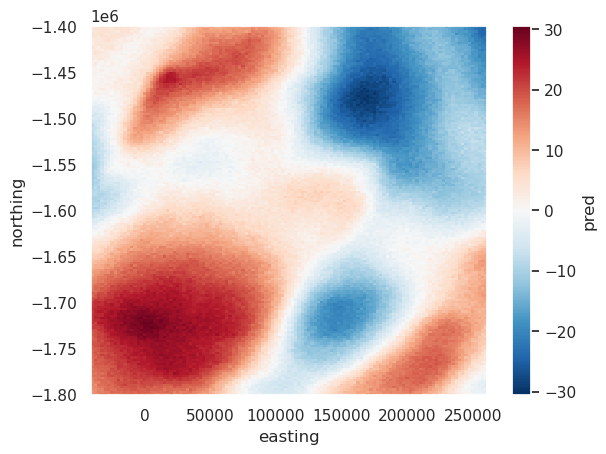

In [30]:
# add optional noise
grav_df["pred"] = synthetic.contaminate(
    grav_df.pred,
    stddev=0.02,
    percent=True,
    seed=0,
)

survey_grid = grav_df.set_index(["northing", "easting"]).to_xarray().pred
survey_grid.plot()

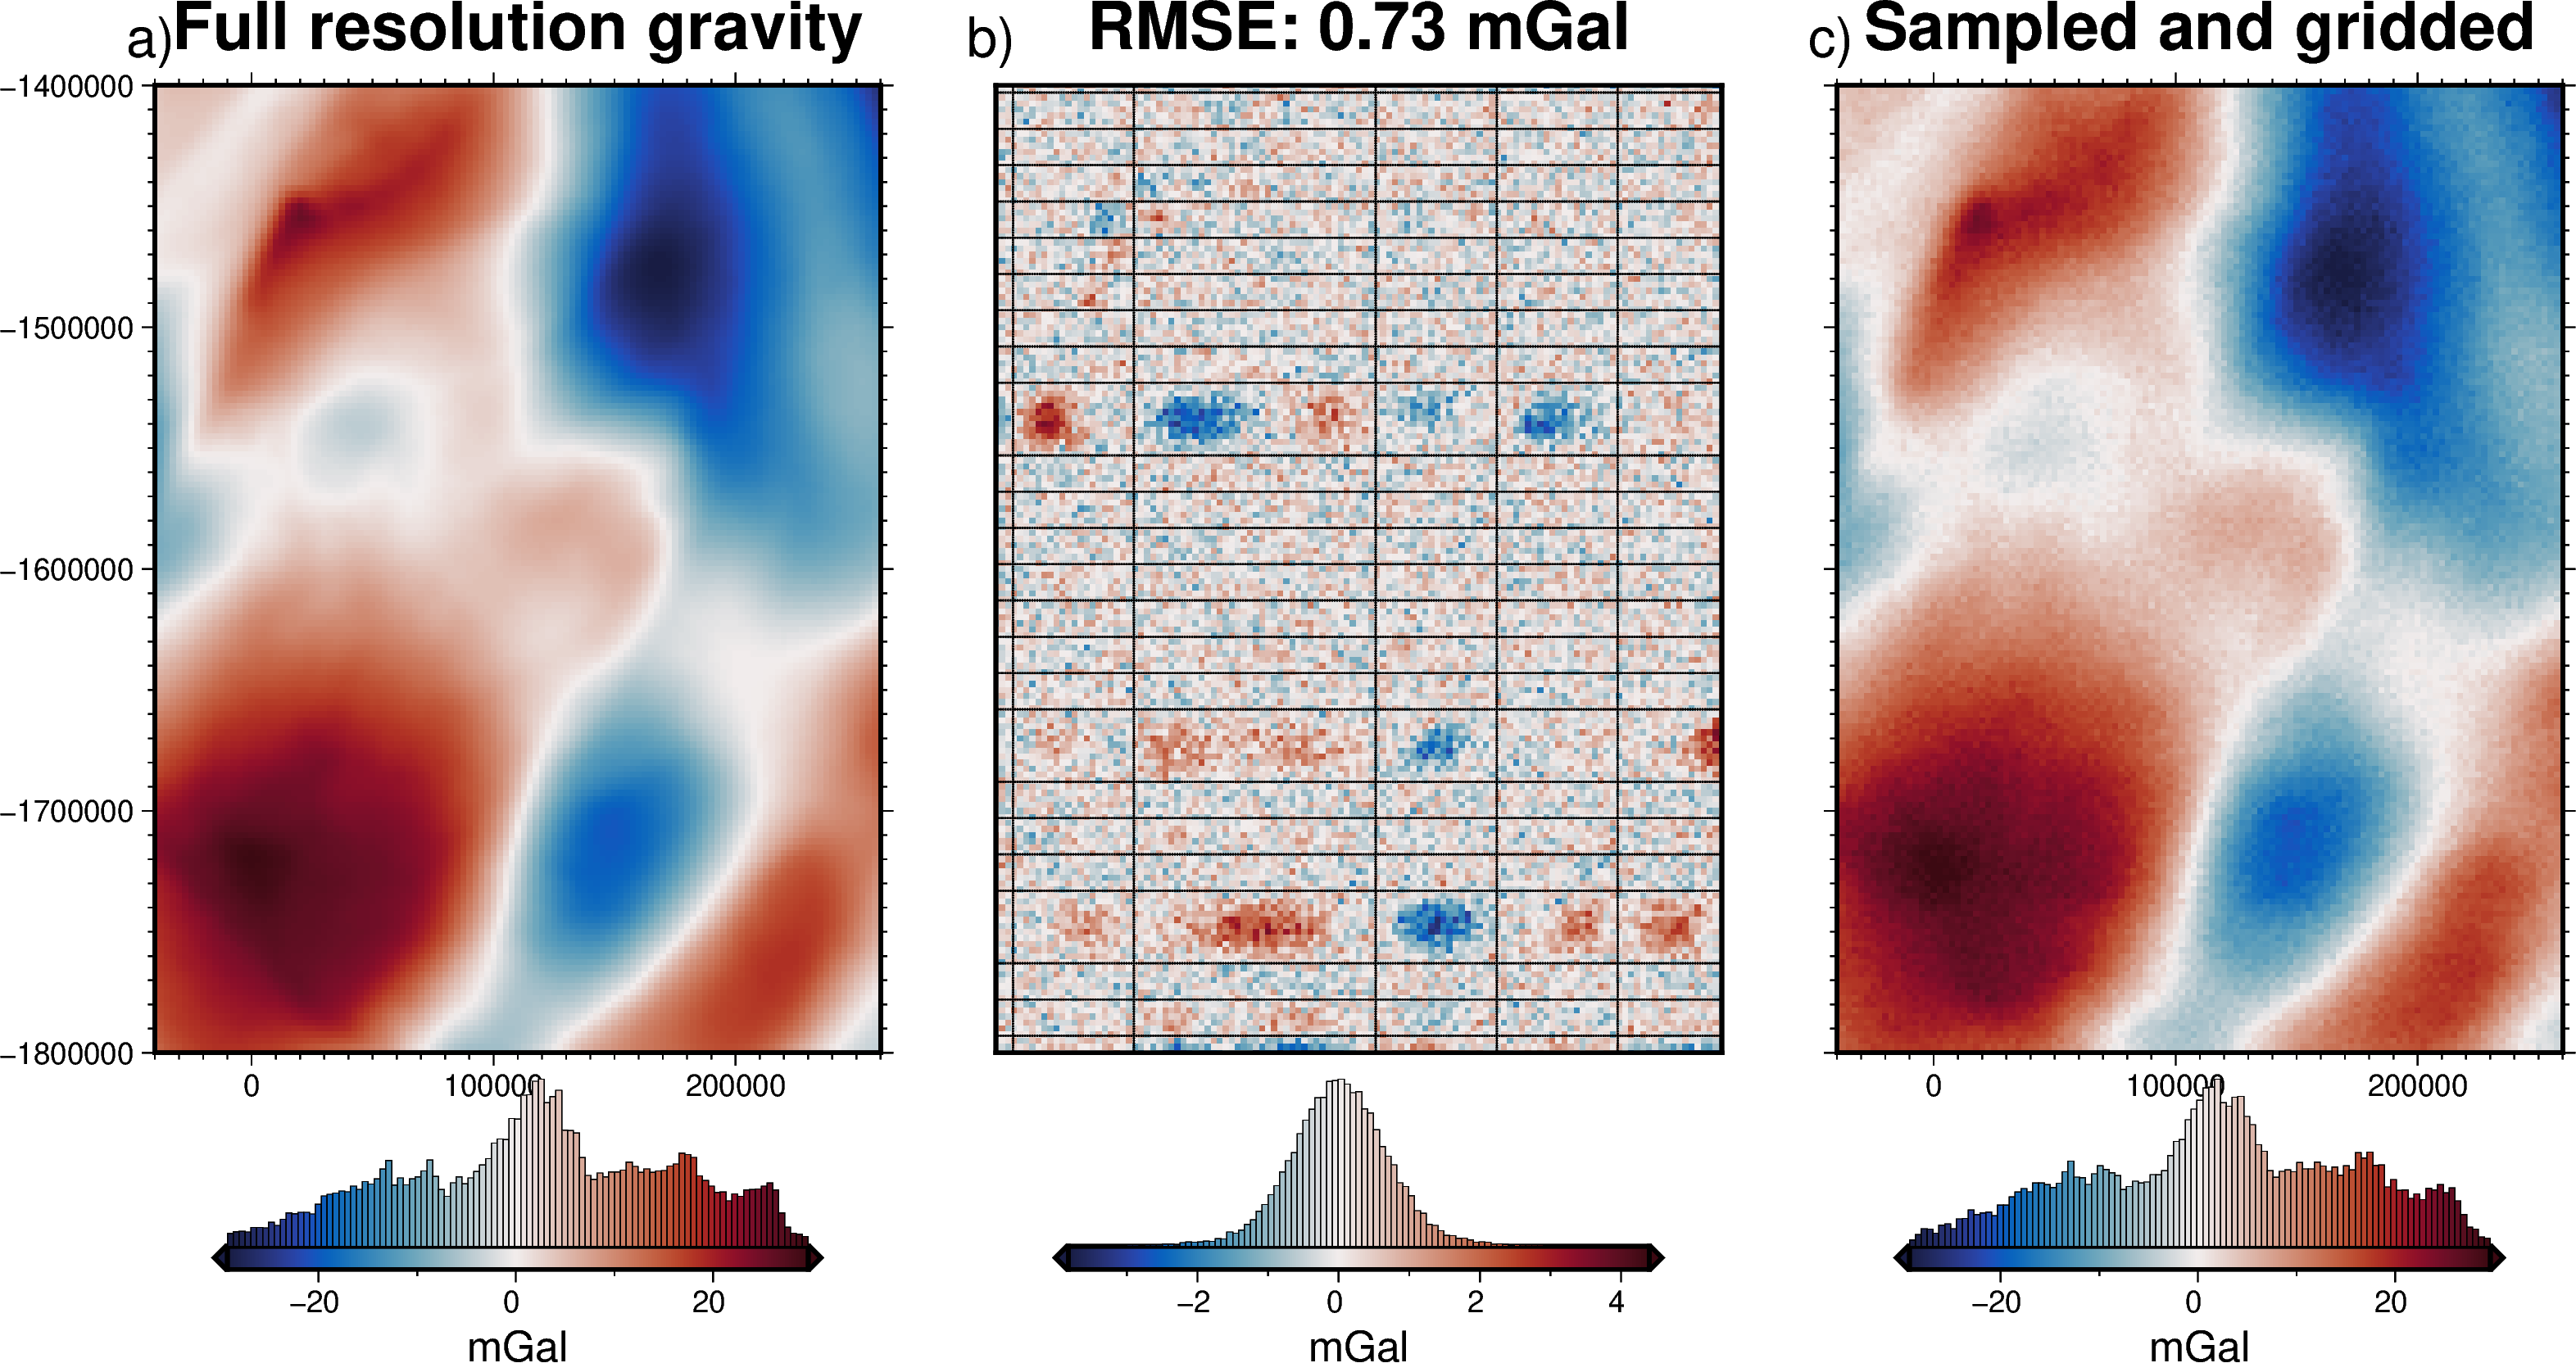

In [31]:
# plot the synthetic gravity anomaly grid

lims = utils.get_min_max(forward_grids.forward_total)

fig = maps.plot_grd(
    forward_grids.forward_total,
    fig_height=10,
    cmap="balance+h0",
    cpt_lims=lims,
    title="Full resolution gravity",
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
    hist=True,
    cbar_yoffset=2,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="16p,Helvetica,black",
    offset="j-.3/.3",
    no_clip=True,
)

dif = (
    forward_grids.forward_total - survey_grid
)  # .rename({"x":"easting", "y":"northing"})
fig = maps.plot_grd(
    dif,
    fig_height=10,
    cmap="balance+h0",
    title=f"RMSE: {round(inv_utils.RMSE(dif),2)} mGal",
    cbar_label="mGal",
    hist=True,
    cbar_yoffset=2,
    grd2_cpt=True,
    fig=fig,
    origin_shift="xshift",
    xshift_amount=1.1,
)

# plot observation points
fig.plot(grav_survey[["easting", "northing"]], style="c.02c", color="black")
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="16p,Helvetica,black",
    offset="j-.3/.3",
    no_clip=True,
)

# plot the synthetic observed gravity grid
fig = maps.plot_grd(
    survey_grid,
    fig_height=10,
    cmap="balance+h0",
    cpt_lims=lims,
    title="Sampled and gridded",
    cbar_label="mGal",
    frame=["nSwe", "xaf10000", "yaf10000"],
    hist=True,
    cbar_yoffset=2,
    fig=fig,
    origin_shift="xshift",
    xshift_amount=1.1,
)
fig.text(
    position="TL",
    justify="BL",
    text="c)",
    font="16p,Helvetica,black",
    offset="j-.3/.3",
    no_clip=True,
)
fig.show()

# Create low-resolution bathymetry
## random constraint points

First, we will create a shapefile which represents the border of an ice shelf (groundingline / calving front)

In [ ]:
# polygon = regions.draw_region(points=utils.region_to_df(inversion_region))

In [ ]:
# create mask grid
# mask = utils.mask_from_polygon(polygon, region=inversion_region, spacing=layer_spacing).rename({"x":"easting","y":"northing"})
# mask.to_netcdf("../data/Ross_Sea_polygon.nc")
# # mask.plot()

In [ ]:
# # create shapefile from mask to use later
# points = utils.shapes_to_df(polygon)
# gdf = gpd.GeoDataFrame(
#     index=[0],
#     geometry=[Polygon(zip(points.x, points.y))],
# )
# gdf.to_file("../data/Ross_Sea_outline.shp")

In [32]:
df = utils.region_to_df(inversion_region)
gdf = gpd.GeoDataFrame(
    index=[0],
    geometry=[Polygon(zip(df.x, df.y))],
)
gdf.geometry.envelope.buffer(-100e3).buffer(90e3).to_file(
    "../../data/Ross_Sea_outline.shp"
)
# gpd.read_file("../data/Ross_Sea_outline.shp").plot()

In [33]:
x_range = abs(inversion_region[0] - inversion_region[1]) / 1000
y_range = abs(inversion_region[2] - inversion_region[3]) / 1000
inversion_area = x_range * y_range
print(f"inversion region: {round(inversion_area)} km\u00b2")

gdf = gpd.read_file("../../data/Ross_Sea_outline.shp")
ice_shelf_area = gdf.geometry.area.item() / 10**6
print(f"ice shelf area: {round(ice_shelf_area)} km\u00b2")

# compared to Ross Ice Shelf
print(f"Ross Ice Shelf constraint density: 1 constraint per {487000 / 224} km\u00b2")

inversion region: 120000 km²
ice shelf area: 99406 km²
Ross Ice Shelf constraint density: 1 constraint per 2174.1071428571427 km²


In [34]:
# num_constraints = 30
# const_density = inversion_area / num_constraints

# const_density = 2500
const_density = 2500
num_constraints = int(ice_shelf_area / const_density)
print(f"number of constraints: {num_constraints}")
print(f"constraint density: 1 constraint per {const_density} km\u00b2")

number of constraints: 39
constraint density: 1 constraint per 2500 km²


## Random points within ice shelf

In [37]:
# # mask bed inside of ice shelf
# bed_masked = utils.mask_from_shp(
#     shapefile="../data/Ross_Sea_outline.shp",
#     xr_grid=bed,
#     masked=True,
#     # invert=False,
# ).rename("upward")

# # dataframe of bed values
# outside_constraints = vd.grid_to_table(bed_masked).dropna().drop(columns="upward")

# # create random constraints
# coords = vd.scatter_points(
#     region=inversion_region, size=num_constraints * 2, random_state=0
# )
# constraints = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# # check whether points are inside or side of shp
# gdf = gpd.GeoDataFrame(
#     constraints,
#     geometry=gpd.points_from_xy(x=constraints.easting, y=constraints.northing),
#     crs="EPSG:3031",
# )
# constraints["inside"] = gdf.within(
#     gpd.read_file("../data/Ross_Sea_outline.shp").geometry[0]
# )
# constraints.drop(columns="geometry", inplace=True)

# # keep only set number of constraints
# inside_constraints = constraints[constraints.inside].sample(
#     n=num_constraints, random_state=0
# )

# # merge with outside constraints
# outside_constraints["inside"] = False

# constraints = pd.concat([outside_constraints, inside_constraints])
# constraints[constraints.inside].describe()

In [38]:
# fig = maps.plot_grd(
#     bed,
#     region=buffer_region,
#     show_region=inversion_region,
#     cbar_labels="bed elevation",
#     cbar_units="m",
# )

# fig.plot(
#     x=constraints[constraints.inside].easting,
#     y=constraints[constraints.inside].northing,
#     style="c.2c",
#     fill="black",
# )

# fig.plot(
#     region=buffer_region,
#     x=constraints[constraints.inside == False].easting,
#     y=constraints[constraints.inside == False].northing,
#     style="c.08c",
#     fill="black",
# )

# fig.plot(
#     "../data/Ross_Sea_outline.shp",
#     pen="0.8p,black",
# )

# fig.show()

In [39]:
# constraints = profile.sample_grids(
#     constraints, bed, "upward", coord_names=("easting", "northing")
# )

# # grid with verde
# # spline = vd.Spline()  #damping=1e-20)
# # coords = (constraints.easting, constraints.northing)
# # spline.fit(coords, constraints.upward)
# # lowres_bed = spline.grid(egion=buffer_region, spacing=layer_spacing).scalars
# # print(np.mean(vd.cross_val_score(spline, coords, constraints.upward)))
# # print(spline.score(coords, constraints.upward))

# dampings = list(np.logspace(-20, -5, num=3))
# dampings.insert(0, None)

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore", sp.linalg.LinAlgWarning)
#     spline = inv_utils.best_SplineCV(
#         coordinates = (constraints.easting, constraints.northing),
#         data = constraints.upward,
#         dampings=dampings,
#         delayed=True,
#     )
# lowres_bed = spline.grid(region=buffer_region, spacing=layer_spacing,).scalars

# # lowres_bed2 = pygmt.surface(
# #     data=constraints[['easting', 'northing', 'upward']],
# #     region=buffer_region,
# #     spacing=layer_spacing,
# #     registration=registration,
# #     T=0.35,
# #     verbose="q",
# # )#.rename({"x": "easting", "y": "northing"})

# # lowres_bed.plot()

In [40]:
# # resample to check values are same at constraints
# check = profile.sample_grids(
#     constraints, lowres_bed, "lowres", coord_names=("easting", "northing")
# )
# check["dif"] = check.upward - check.lowres
# check.describe()

In [41]:
# output = lowres_bed.to_dataset(name="z")
# output.to_zarr(
#     "../synthetic_data/Ross_Sea_lowres_bed.zarr",
#     encoding={"z": {"compressor": zarr.Blosc()}},
#     mode="w",
# )

In [42]:
# lowres_bed = xr.open_zarr("../synthetic_data/Ross_Sea_lowres_bed.zarr").z
# utils.get_grid_info(lowres_bed)

In [43]:
# constraints.to_csv(
#     "../synthetic_data/Ross_Sea_synthetic_constraints.csv.gz",
#     sep=",",
#     na_rep="",
#     header=True,
#     index=False,
#     encoding="utf-8",
#     compression="gzip",
# )

In [44]:
# constraints = pd.read_csv(
#     "../synthetic_data/Ross_Sea_synthetic_constraints.csv.gz",
#     sep=",",
#     header="infer",
#     index_col=None,
#     compression="gzip",
# )

In [45]:
# # compare starting and actual bed
# bed_inner = bed.sel(
#     easting=slice(inversion_region[0], inversion_region[1]),
#     northing=slice(inversion_region[2], inversion_region[3]),
# )
# lowres_bed_inner = lowres_bed.sel(
#     easting=slice(inversion_region[0], inversion_region[1]),
#     northing=slice(inversion_region[2], inversion_region[3]),
# )

# dif = bed_inner - lowres_bed_inner

# rms = utils.RMSE(dif)
# robust = True
# lims_a = utils.get_min_max(bed, robust=robust)
# lims_b = utils.get_min_max(lowres_bed, robust=robust)
# lims = (min((lims_a[0], lims_b[0])), max(lims_a[1], lims_b[1]))

# fig = maps.plot_grd(
#     bed,
#     # fig_height=10,
#     region=inversion_region,
#     cbar_label="elevation",
#     cbar_unit="m",
#     title="True bathymetry",
#     cmap="rain",
#     cpt_lims=lims,
#     reverse_cpt=True,
#     points=constraints[constraints.inside].rename(
#         columns={"easting": "x", "northing": "y"}
#     ),
#     points_style="c.08c",
#     inset=False,
#     hist=True,
#     # robust=True,
# )
# fig.plot(
#     x=constraints[constraints.inside == False].easting,
#     y=constraints[constraints.inside == False].northing,
#     style="c.04c",
#     fill="black",
# )
# fig.plot(
#     "../data/Ross_Sea_outline.shp",
#     pen="0.8p,black",
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="a)",
#     font="20p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )
# fig = maps.plot_grd(
#     dif,
#     region=inversion_region,
#     cbar_label="elevation",
#     cbar_unit="m",
#     title=f"Difference, RMSE {round(rms,2)} m",
#     cmap="vik+h0",
#     points=constraints[constraints.inside].rename(
#         columns={"easting": "x", "northing": "y"}
#     ),
#     points_style="c.08c",
#     inset=False,
#     hist=True,
#     robust=True,
#     fig=fig,
#     origin_shift="xshift",
# )
# fig.plot(
#     x=constraints[constraints.inside == False].easting,
#     y=constraints[constraints.inside == False].northing,
#     style="c.04c",
#     fill="black",
# )
# fig.plot(
#     "../data/Ross_Sea_outline.shp",
#     pen="0.8p,black",
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="b)",
#     font="20p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )
# fig = maps.plot_grd(
#     lowres_bed,
#     region=inversion_region,
#     cbar_label="elevation",
#     cbar_unit="m",
#     title="Starting bathymetry",
#     cmap="rain",
#     cpt_lims=lims,
#     reverse_cpt=True,
#     points=constraints[constraints.inside].rename(
#         columns={"easting": "x", "northing": "y"}
#     ),
#     points_style="c.08c",
#     inset=False,
#     hist=True,
#     # robust=True,
#     fig=fig,
#     origin_shift="xshift",
# )
# fig.plot(
#     x=constraints[constraints.inside == False].easting,
#     y=constraints[constraints.inside == False].northing,
#     style="c.04c",
#     fill="black",
# )
# fig.plot(
#     "../data/Ross_Sea_outline.shp",
#     pen="0.8p,black",
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="c)",
#     font="20p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )
# fig.show()

## repeat with constraints following a semi-regular grid
divide the ice shelf region into blocks with 1 block per constraint.
Randomly sample point in each box to be the constraint

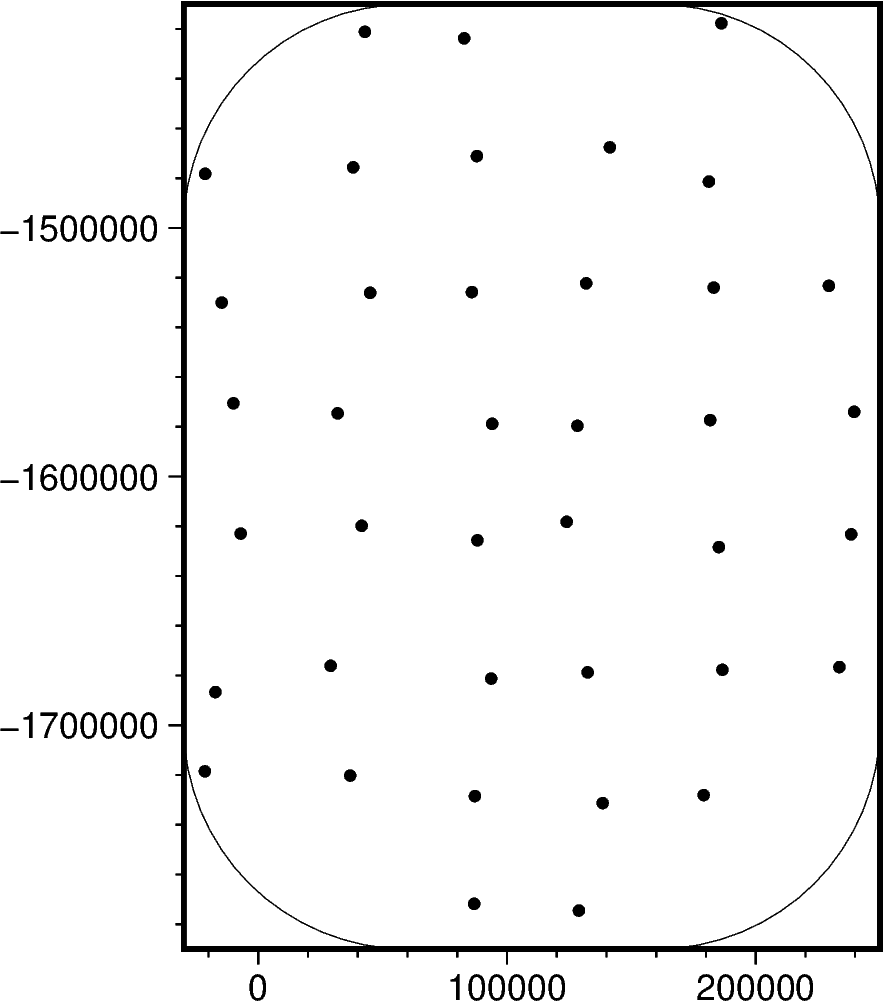

total constraints 3542
inside ice shelf constraints 39


In [47]:
# get constraints outside of ice shelf
bed_masked = utils.mask_from_shp(
    shapefile="../../data/Ross_Sea_outline.shp",
    xr_grid=bed,
    masked=True,
    # invert=False,
).rename("upward")
outside_constraints = vd.grid_to_table(bed_masked).dropna()
outside_constraints.drop(columns="upward", inplace=True)
outside_constraints["inside"] = False

inside_constraints = synthetic.constraint_layout_number(
    num_constraints=num_constraints,
    shift_stdev=5e3,
    region=inversion_region,
    padding=-15e3,
    shapefile="../../data/Ross_Sea_outline.shp",
    plot=True,
)

constraints = pd.concat([outside_constraints, inside_constraints]).drop(
    columns="upward"
)
print("total constraints", len(constraints))
print("inside ice shelf constraints", len(constraints[constraints.inside]))

In [49]:
# fig = maps.plot_grd(
#     bed,
#     region=buffer_region,
#     show_region=inversion_region,
#     cbar_labels="bed elevation",
#     cbar_units="m",
# )

# fig.plot(
#     x=constraints[constraints.inside].easting,
#     y=constraints[constraints.inside].northing,
#     style="c.2c",
#     fill="black",
# )

# fig.plot(
#     region=buffer_region,
#     x=constraints[constraints.inside == False].easting,
#     y=constraints[constraints.inside == False].northing,
#     style="c.08c",
#     fill="black",
# )

# fig.plot(
#     "../data/Ross_Sea_outline.shp",
#     pen="0.8p,black",
# )

# fig.show()

In [50]:
# sampled the bed values at these points
constraints = profile.sample_grids(
    constraints, bed, "upward", coord_names=("easting", "northing")
)
constraints

northing        easting  inside      upward
0  -1.840000e+06  -80000.000000   False -834.308838
1  -1.840000e+06  -75000.000000   False -760.986511
2  -1.840000e+06  -70000.000000   False -715.998108
3  -1.840000e+06  -65000.000000   False -679.995605
4  -1.840000e+06  -60000.000000   False -648.753906
..           ...            ...     ...         ...
8  -1.728519e+06   87149.318474    True -287.656051
25 -1.574530e+06   31910.464776    True -503.984573
38 -1.471080e+06   87905.829062    True -400.734583
23 -1.623242e+06  238418.430954    True -550.929739
21 -1.618168e+06  123982.450597    True -337.408543

[3542 rows x 4 columns]

In [51]:
# add noise to the sampled data
# outside ice shelf is low uncertainty (+/- 5m)
# inside is relative to depth (2% depth from surface)

# add gaussian noise with stdev of 5 m for all points
constraints["upward_with_noise"], constraints["uncert"] = synthetic.contaminate(
    constraints.upward,
    stddev=5,
    percent=False,
    seed=0,
    return_stddev=True,
)

# for inside points, replace with gaussian noise with a stdev of
# 5% of each points depths
noise, uncert = synthetic.contaminate(
    constraints[constraints.inside].upward,
    stddev=0.02,
    percent=True,
    percent_as_max_abs=False,
    seed=0,
    return_stddev=True,
)
constraints.loc[constraints.inside, "upward_with_noise"] = noise
constraints.loc[constraints.inside, "uncert"] = uncert

print(
    "Outside constraints RMS uncertainty:",
    inv_utils.RMSE(constraints[constraints.inside == False].uncert),
)
print(
    "Outside constraints RMS noise / no noise",
    inv_utils.RMSE(
        constraints[constraints.inside == False].upward
        - constraints[constraints.inside == False].upward_with_noise
    ),
)

print(
    "Inside constraints RMS uncertainty:",
    inv_utils.RMSE(constraints[constraints.inside].uncert),
)
print(
    "Inside constraints RMS noise / no noise",
    inv_utils.RMSE(
        constraints[constraints.inside].upward
        - constraints[constraints.inside].upward_with_noise
    ),
)
constraints["noise_dif"] = constraints.upward - constraints.upward_with_noise
constraints

Standard deviation used for noise: [5]
Outside constraints RMS uncertainty: 5.0
Outside constraints RMS noise / no noise 4.8901490951297255
Inside constraints RMS uncertainty: 9.362798249742498
Inside constraints RMS noise / no noise 10.18845167748272


northing        easting  inside      upward  upward_with_noise  \
0  -1.840000e+06  -80000.000000   False -834.308838        -825.360110   
1  -1.840000e+06  -75000.000000   False -760.986511        -758.857259   
2  -1.840000e+06  -70000.000000   False -715.998108        -710.975952   
3  -1.840000e+06  -65000.000000   False -679.995605        -668.662673   
4  -1.840000e+06  -60000.000000   False -648.753906        -639.287650   
..           ...            ...     ...         ...                ...   
8  -1.728519e+06   87149.318474    True -287.656051        -292.486677   
25 -1.574530e+06   31910.464776    True -503.984573        -505.237670   
38 -1.471080e+06   87905.829062    True -400.734583        -393.703229   
23 -1.623242e+06  238418.430954    True -550.929739        -540.510249   
21 -1.618168e+06  123982.450597    True -337.408543        -342.851337   

       uncert  noise_dif  
0    5.000000  -8.948728  
1    5.000000  -2.129252  
2    5.000000  -5.022156  
3    5.000000 -11.332932  
4    5.000000  -9.466256  
..        ...        ...  
8    5.753121   4.830627  
25  10.079691   1.253097  
38   8.014692  -7.031354  
23  11.018595 -10.419490  
21   6.748171   5.442794  

[3542 rows x 7 columns]

Highest score: 0.9953772568026569
Best damping: None


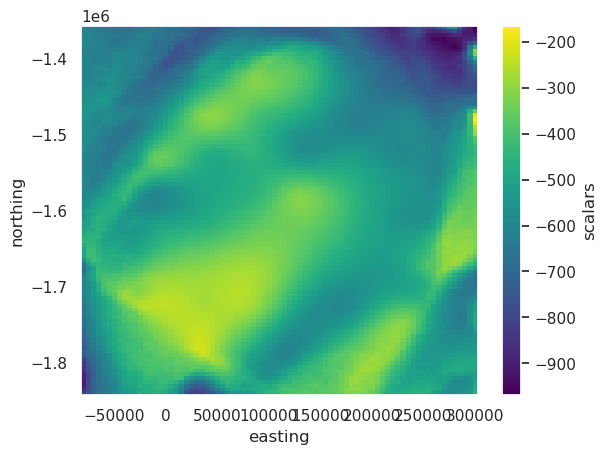

In [52]:
dampings = list(np.logspace(-20, -5, num=2))
dampings.insert(0, None)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", sp.linalg.LinAlgWarning)
    spline = inv_utils.best_SplineCV(
        coordinates=(constraints.easting, constraints.northing),
        data=constraints.upward_with_noise,
        # data = constraints.upward,
        dampings=dampings,
        delayed=True,
    )
lowres_bed_semiregular = spline.grid(
    region=buffer_region,
    spacing=layer_spacing,
).scalars

lowres_bed_semiregular.plot()

Highest score: 0.9964019252315411
Best damping: 1e-20


/Users/home/tankerma/RIS_gravity_inversion/RIS_gravity_inversion/utils.py:175: UserWarning: Warning: best damping parameter (1e-20) for verde.SplineCV() is at the limit of provided values ((1e-20, 1e-05)) and thus is likely not a global minimum, expand the range of values with 'dampings'
  warnings.warn(


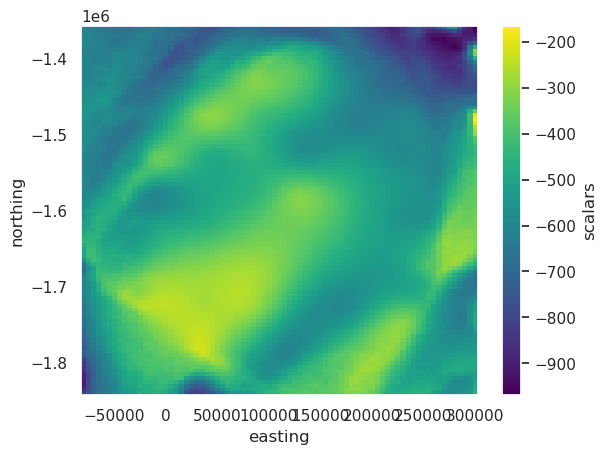

In [53]:
dampings = list(np.logspace(-20, -5, num=3))
# dampings.insert(0, None)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", sp.linalg.LinAlgWarning)
    spline = inv_utils.best_SplineCV(
        coordinates=(constraints.easting, constraints.northing),
        data=constraints.upward_with_noise,
        # data = constraints.upward,
        weights=1 / (constraints.uncert**2),
        dampings=dampings,
        delayed=True,
    )
lowres_bed_semiregular_weights = spline.grid(
    region=buffer_region,
    spacing=layer_spacing,
).scalars

lowres_bed_semiregular_weights.plot()

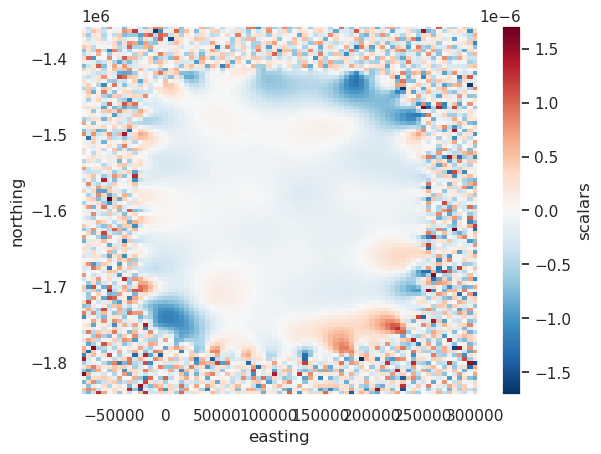

In [54]:
(lowres_bed_semiregular - lowres_bed_semiregular_weights).plot()  # robust=True)

In [55]:
# resample to check values are same at constraints
check = profile.sample_grids(
    constraints[constraints.inside],
    lowres_bed_semiregular_weights,
    "bed",
    coord_names=("easting", "northing"),
)
check["dif"] = check.upward_with_noise - check.bed

rms = utils.RMSE(check.dif)
print(f"RMSE with lowres bed at constraints: {rms} mGal")

RMSE with lowres bed at constraints: 0.42409902696453117 mGal


In [56]:
# resample to check values are same at constraints
check = profile.sample_grids(
    constraints[constraints.inside], bed, "bed", coord_names=("easting", "northing")
)
check["dif"] = check.upward_with_noise - check.bed

rms = utils.RMSE(check.dif)
print(f"RMS with real bed at constraints: {rms} mGal")

RMS with real bed at constraints: 10.18845167748272 mGal


In [57]:
output = lowres_bed_semiregular_weights.to_dataset(name="z")
output.to_zarr(
    "../../synthetic_data/Ross_Sea_lowres_bed_semiregular.zarr",
    encoding={"z": {"compressor": zarr.Blosc()}},
    mode="w",
)

In [10]:
lowres_bed_semiregular = xr.open_zarr(
    "../../synthetic_data/Ross_Sea_lowres_bed_semiregular.zarr"
).z
utils.get_grid_info(lowres_bed_semiregular)

(5000.0,
 [-80000.0, 300000.0, -1840000.0, -1360000.0],
 -969.619506836,
 -164.541534424,
 'g')

In [59]:
constraints.drop(columns=["upward", "noise_dif"], inplace=True)
constraints.rename(columns={"upward_with_noise": "upward"}, inplace=True)
constraints

northing        easting  inside      upward     uncert
0  -1.840000e+06  -80000.000000   False -825.360110   5.000000
1  -1.840000e+06  -75000.000000   False -758.857259   5.000000
2  -1.840000e+06  -70000.000000   False -710.975952   5.000000
3  -1.840000e+06  -65000.000000   False -668.662673   5.000000
4  -1.840000e+06  -60000.000000   False -639.287650   5.000000
..           ...            ...     ...         ...        ...
8  -1.728519e+06   87149.318474    True -292.486677   5.753121
25 -1.574530e+06   31910.464776    True -505.237670  10.079691
38 -1.471080e+06   87905.829062    True -393.703229   8.014692
23 -1.623242e+06  238418.430954    True -540.510249  11.018595
21 -1.618168e+06  123982.450597    True -342.851337   6.748171

[3542 rows x 5 columns]

In [60]:
constraints.to_csv(
    "../../synthetic_data/Ross_Sea_synthetic_constraints_semiregular.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [11]:
constraints = pd.read_csv(
    "../../synthetic_data/Ross_Sea_synthetic_constraints_semiregular.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
constraints

northing        easting  inside      upward     uncert
0    -1.840000e+06  -80000.000000   False -825.360110   5.000000
1    -1.840000e+06  -75000.000000   False -758.857259   5.000000
2    -1.840000e+06  -70000.000000   False -710.975952   5.000000
3    -1.840000e+06  -65000.000000   False -668.662673   5.000000
4    -1.840000e+06  -60000.000000   False -639.287650   5.000000
...            ...            ...     ...         ...        ...
3537 -1.728519e+06   87149.318474    True -292.486677   5.753121
3538 -1.574530e+06   31910.464776    True -505.237670  10.079691
3539 -1.471080e+06   87905.829062    True -393.703229   8.014692
3540 -1.623242e+06  238418.430954    True -540.510249  11.018595
3541 -1.618168e+06  123982.450597    True -342.851337   6.748171

[3542 rows x 5 columns]

RMS with real bed at constraints: 10.188451677482723 mGal


<Axes: >

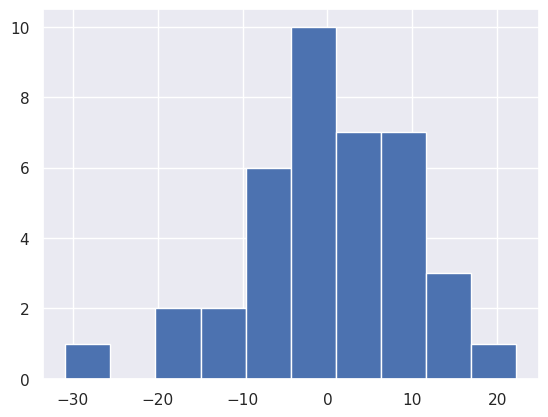

In [62]:
# resample to check values are same at constraints
check = profile.sample_grids(
    constraints[constraints.inside], bed, "bed", coord_names=("easting", "northing")
)
check["dif"] = check.upward - check.bed

rms = utils.RMSE(check.dif)
print(f"RMS with real bed at constraints: {rms} mGal")
check.dif.hist()

RMS with starting bed at constraints: 0.42409902696453683 mGal


<Axes: >

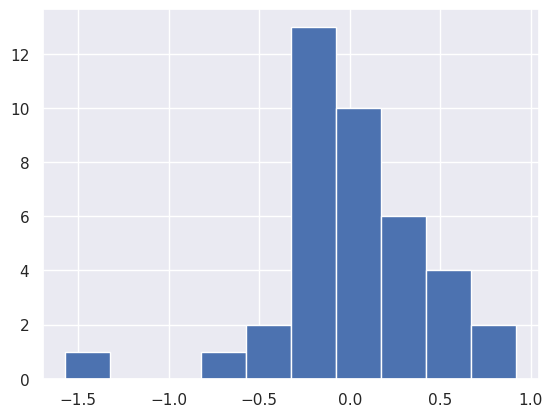

In [63]:
# resample to check values are same at constraints
check = profile.sample_grids(
    constraints[constraints.inside],
    lowres_bed_semiregular,
    "bed",
    coord_names=("easting", "northing"),
)
check["dif"] = check.upward - check.bed

rms = utils.RMSE(check.dif)
print(f"RMS with starting bed at constraints: {rms} mGal")
check.dif.hist()

In [64]:
print(len(constraints[constraints.inside]))
print(len(constraints[constraints.inside == False]))

39
3503


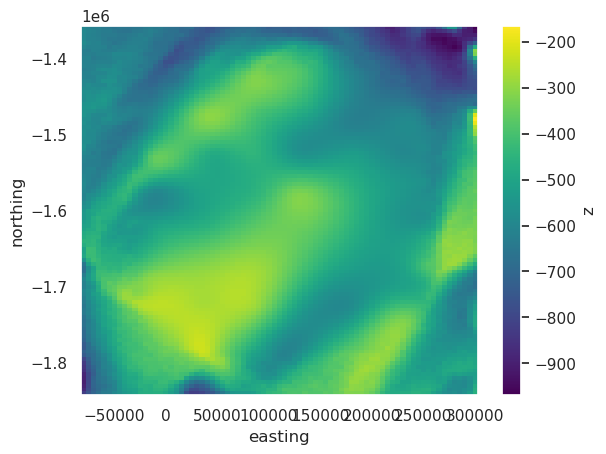

In [65]:
lowres_bed_semiregular.plot()

grd2cpt [WARNING]: dense is a discrete CPT. You can stretch it (-T<min>/<max>) but not interpolate it (-T<min>/<max>/<inc>).
grd2cpt [WARNING]: Selecting the given range and ignoring the increment setting.
grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


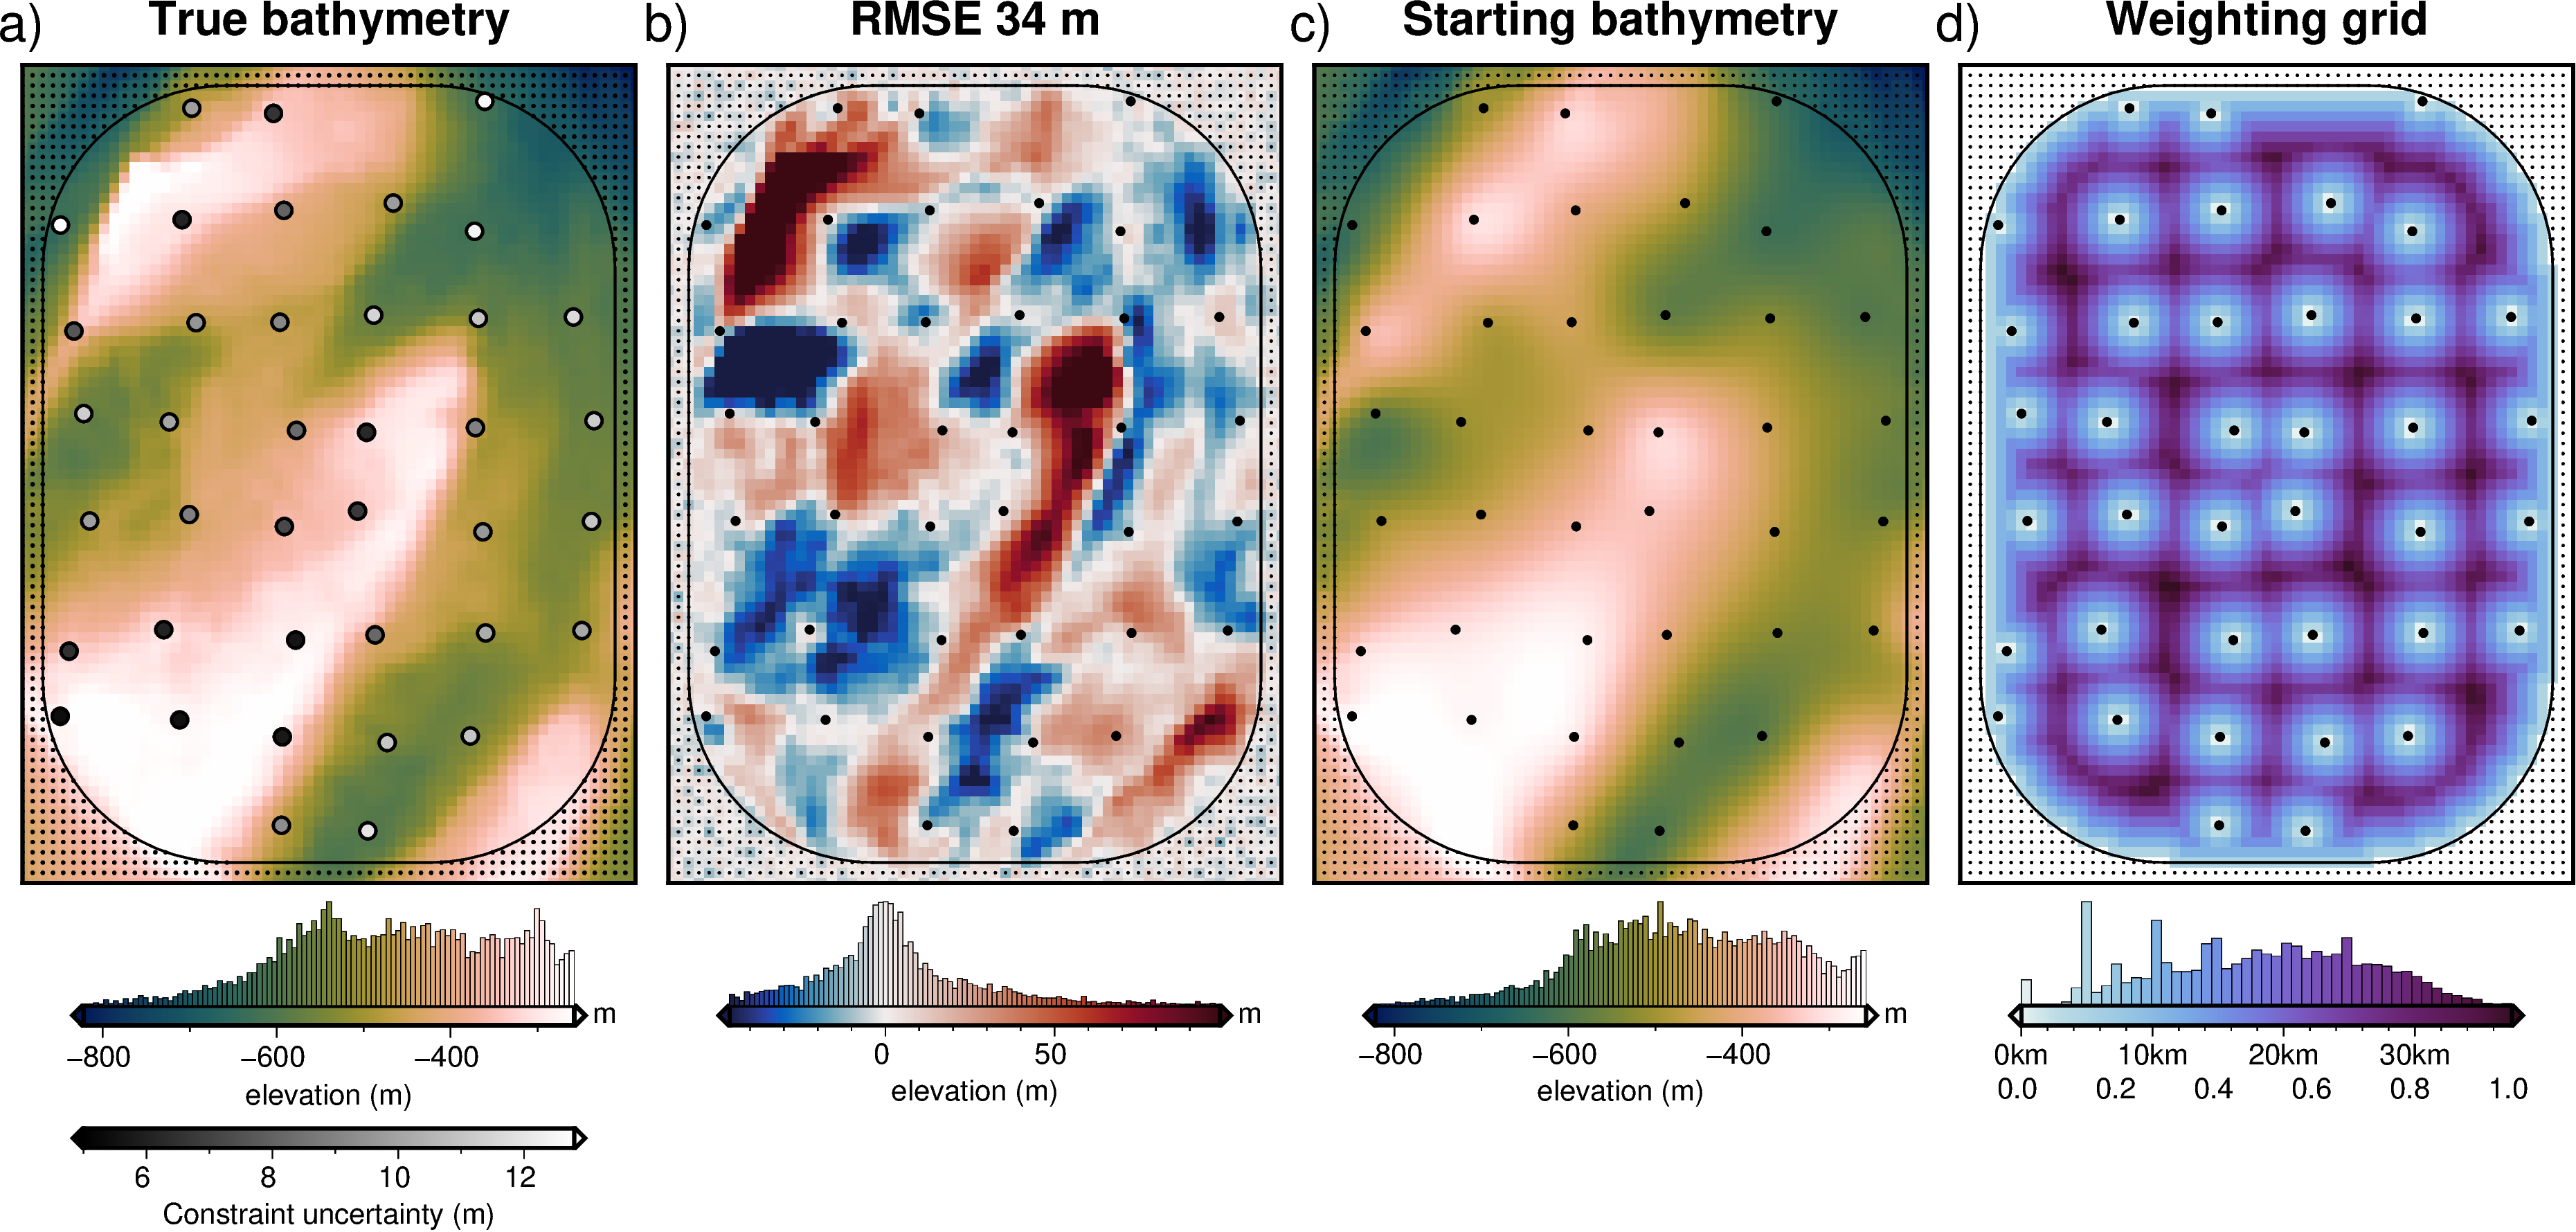

In [15]:
# compare starting and actual bed
bed_inner = bed.sel(
    easting=slice(inversion_region[0], inversion_region[1]),
    northing=slice(inversion_region[2], inversion_region[3]),
)
lowres_bed_semiregular_inner = lowres_bed_semiregular.sel(
    easting=slice(inversion_region[0], inversion_region[1]),
    northing=slice(inversion_region[2], inversion_region[3]),
)

dif = bed_inner - lowres_bed_semiregular_inner
rms = utils.RMSE(dif)
robust = True
lims_a = utils.get_min_max(bed, robust=robust)
lims_b = utils.get_min_max(lowres_bed_semiregular, robust=robust)
lims = (min((lims_a[0], lims_b[0])), max(lims_a[1], lims_b[1]))

# fig = maps.plot_grd(
#     bed,
#     fig_height=10,
#     region=inversion_region,
#     cbar_label="elevation",
#     cbar_unit="m",
#     title="True bathymetry",
#     cmap="rain",
#     cpt_lims=lims,
#     reverse_cpt=True,
#     points=constraints[constraints.inside].rename(
#         columns={"easting": "x", "northing": "y"}
#     ),
#     points_style="c.08c",
#     inset=False,
#     hist=True,
#     cbar_yoffset=1.5,
#     title_font="16p,Helvetica-Bold",
#     # robust=True,
# )
# fig.plot(
#     x=constraints[constraints.inside == False].easting,
#     y=constraints[constraints.inside == False].northing,
#     style="c.04c",
#     fill="black",
# )
fig = maps.plot_grd(
    bed,
    fig_height=10,
    region=inversion_region,
    cbar_label="elevation (m)",
    cbar_unit="m",
    title="True bathymetry",
    cmap="batlowW",
    cpt_lims=lims,
    inset=False,
    hist=True,
    cbar_yoffset=1.5,
    title_font="16p,Helvetica-Bold",
    # robust=True,
)

fig.plot(
    "../../data/Ross_Sea_outline.shp",
    pen="0.8p,black",
)
pygmt.makecpt(
    cmap="gray",
    series=utils.get_min_max(constraints.uncert),
)
fig.plot(
    x=constraints[constraints.inside == False].easting,
    y=constraints[constraints.inside == False].northing,
    style="c.05c",
    fill=constraints[constraints.inside == False].uncert,
    cmap=True,
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    style="c.2c",
    fill=constraints[constraints.inside].uncert,
    cmap=True,
    pen="1p,black",
)
maps.add_colorbar(fig=fig, cbar_label="Constraint uncertainty (m)", cbar_yoffset=3)

fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="18p,Helvetica,black",
    offset="j-.3/.3",
    no_clip=True,
)
fig = maps.plot_grd(
    dif,
    region=inversion_region,
    cbar_label="elevation (m)",
    cbar_unit="m",
    title=f"RMSE {int(rms)} m",
    cmap="balance+h0",
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    points_style="c.08c",
    inset=False,
    hist=True,
    cbar_yoffset=1.5,
    robust=True,
    title_font="16p,Helvetica-Bold",
    fig=fig,
    origin_shift="xshift",
)
fig.plot(
    x=constraints[constraints.inside == False].easting,
    y=constraints[constraints.inside == False].northing,
    style="c.04c",
    fill="black",
)
fig.plot(
    "../../data/Ross_Sea_outline.shp",
    pen="0.8p,black",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="18p,Helvetica,black",
    offset="j-.3/.3",
    no_clip=True,
)
fig = maps.plot_grd(
    lowres_bed_semiregular,
    region=inversion_region,
    cbar_label="elevation (m)",
    cbar_unit="m",
    title="Starting bathymetry",
    cmap="batlowW",
    cpt_lims=lims,
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    points_style="c.08c",
    inset=False,
    hist=True,
    cbar_yoffset=1.5,
    # robust=True,
    title_font="16p,Helvetica-Bold",
    fig=fig,
    origin_shift="xshift",
)
fig.plot(
    x=constraints[constraints.inside == False].easting,
    y=constraints[constraints.inside == False].northing,
    style="c.04c",
    fill="black",
)
fig.plot(
    "../../data/Ross_Sea_outline.shp",
    pen="0.8p,black",
)
fig.text(
    position="TL",
    justify="BL",
    text="c)",
    font="18p,Helvetica,black",
    offset="j-.3/.3",
    no_clip=True,
)


starting_bed = copy.deepcopy(lowres_bed_semiregular)
weights = inv_utils.normalized_mindist(
    constraints,
    starting_bed,
    mindist=layer_spacing / np.sqrt(2),
    low=0,
    high=1,
    region=inversion_region,
)
starting_bed["weights"] = weights
min_dist = inv_utils.normalized_mindist(
    constraints,
    starting_bed,
    mindist=layer_spacing / np.sqrt(2),
)
min_dist = utils.mask_from_shp(
    gpd.read_file("../../data/Ross_Sea_outline.shp"),
    xr_grid=min_dist,
    masked=True,
    invert=False,
)
fig = maps.plot_grd(
    min_dist,
    region=inversion_region,
    title="Weighting grid",
    title_font="16p,Helvetica-Bold",
    cmap="dense",
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    points_style="c.08c",
    hist=True,
    cbar_yoffset=1.5,
    cbar_unit_annot="km",
    cbar_scale=0.001,
    hist_bin_num=50,
    fig=fig,
    origin_shift="xshift",
)
fig.plot(
    x=constraints[constraints.inside == False].easting,
    y=constraints[constraints.inside == False].northing,
    style="c.04c",
    fill="black",
)
fig.plot(
    "../../data/Ross_Sea_outline.shp",
    pen="0.8p,black",
)
fig.text(
    position="TL",
    justify="BL",
    text="d)",
    font="18p,Helvetica,black",
    offset="j-.3/.3",
    no_clip=True,
)
pygmt.grd2cpt(
    grid=starting_bed.weights,
    continuous=True,
    background="i",
    cmap="dense",
)
with pygmt.config(
    FONT_ANNOT="Helvetica-Oblique",
    MAP_ANNOT_OFFSET_PRIMARY="18p",
    MAP_TICK_LENGTH_PRIMARY="0p",
):
    maps.add_colorbar(fig=fig, cbar_yoffset=1.5)


fig.show()

In [ ]:
min_dist = inv_utils.normalized_mindist(
    constraints,
    starting_bed_prisms,
    mindist=layer_spacing / np.sqrt(2),
)

min_dist = utils.mask_from_shp(
    gpd.read_file("../plotting/RIS_outline.shp").buffer(-5e3),
    # "../plotting/RIS_outline.shp",
    xr_grid=min_dist,
    masked=True,
    invert=False,
)
fig = maps.plot_grd(
    min_dist,
    coast=True,
    coast_version="measures-v2",
    region=inversion_region,
    fig_height=10,
    title="Weighting grid",
    # title_font="12p,Helvetica-Bold",
    cmap="dense",
    hist=True,
    cbar_yoffset=1.5,
    cbar_unit_annot="km",
    cbar_scale=0.001,
    hist_bin_num=50,
)

fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    style="x0.12c",
    pen=".5p",
    label="Ice shelf constraints",
)
fig.plot(
    x=constraints[constraints.inside == False].easting,
    y=constraints[constraints.inside == False].northing,
    style="p",
    # pen='.5p',
    label="Outside constraints",
)

pygmt.grd2cpt(
    grid=starting_bed_prisms.weights,
    continuous=True,
    background="i",
    cmap="dense",
)
with pygmt.config(
    FONT_ANNOT="Helvetica-Oblique",
    MAP_ANNOT_OFFSET_PRIMARY="18p",
    MAP_TICK_LENGTH_PRIMARY="0p",
):
    maps.add_colorbar(fig=fig, cbar_yoffset=1.5)

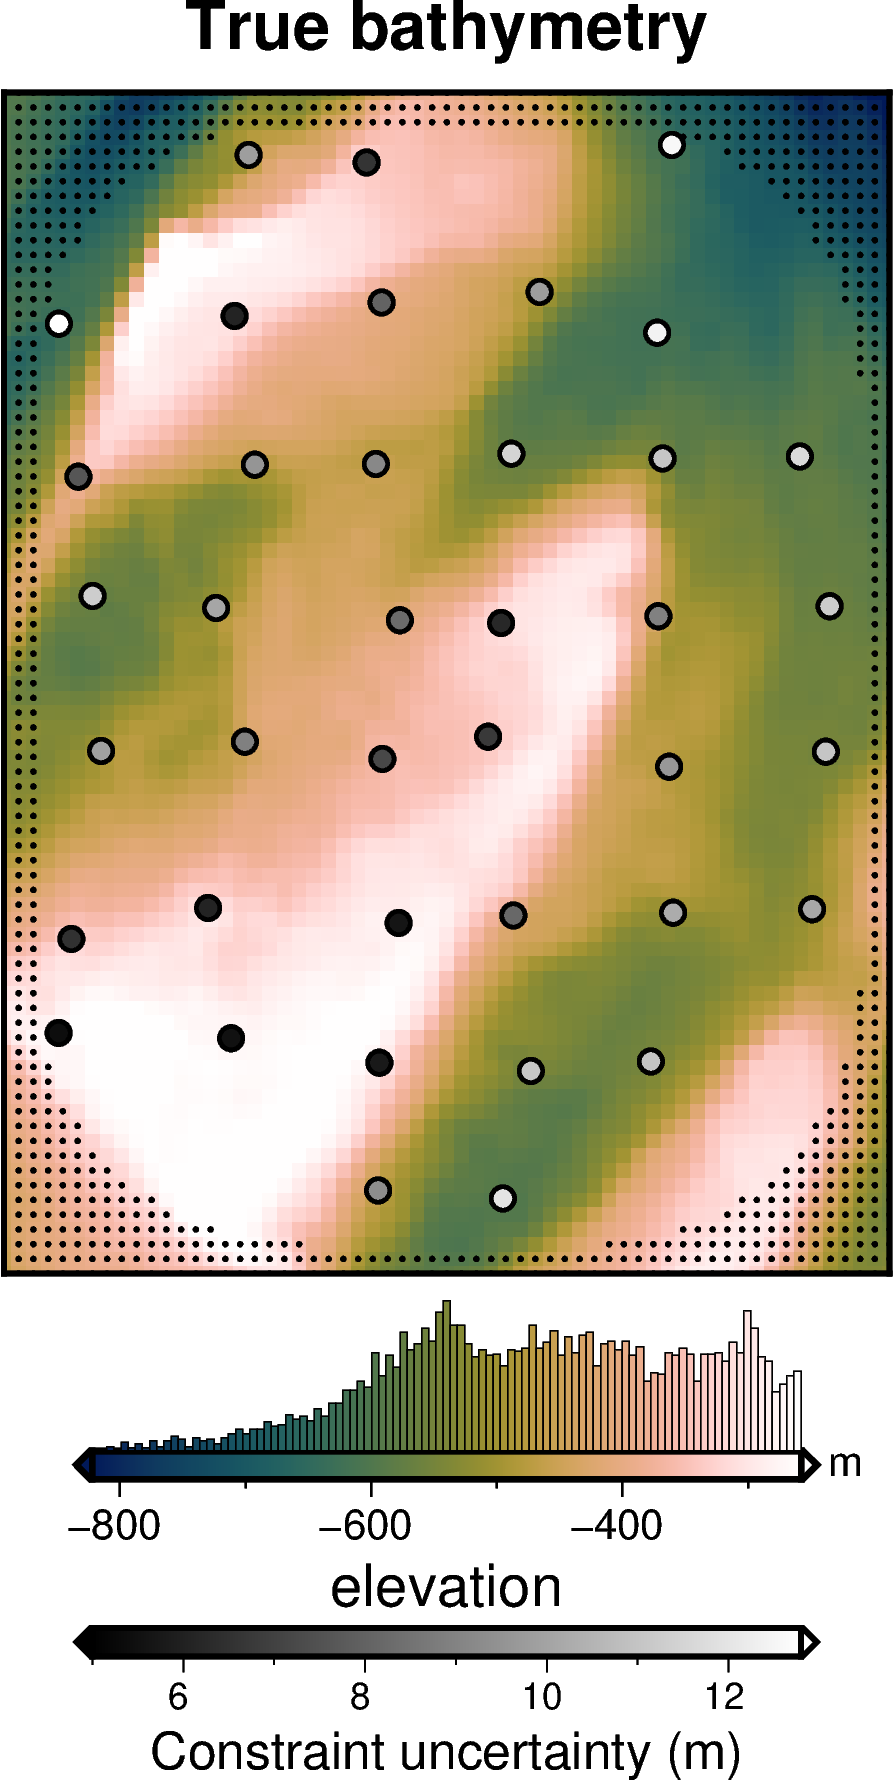

In [69]:
fig = maps.plot_grd(
    bed,
    fig_height=10,
    region=inversion_region,
    cbar_label="elevation",
    cbar_unit="m",
    title="True bathymetry",
    cmap="batlowW",
    cpt_lims=lims,
    inset=False,
    hist=True,
    cbar_yoffset=1.5,
    title_font="16p,Helvetica-Bold",
    # robust=True,
)
pygmt.makecpt(
    cmap="gray",
    series=utils.get_min_max(constraints.uncert),
)
fig.plot(
    x=constraints[constraints.inside == False].easting,
    y=constraints[constraints.inside == False].northing,
    style="c.05c",
    fill=constraints[constraints.inside == False].uncert,
    cmap=True,
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    style="c.2c",
    fill=constraints[constraints.inside].uncert,
    cmap=True,
    pen="1p,black",
)
maps.add_colorbar(fig=fig, cbar_label="Constraint uncertainty (m)", cbar_yoffset=3)

fig.show()